In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import plotly.graph_objects as go

from data_processing.data_loader import *
from model.activation_layers import ExULayer, ReLULayer, LipschitzMonotonicLayer
from model.model_network import HierarchNeuralAdditiveModel
from utils.model_architecture_type import get_defult_architecture_phase1, get_defult_architecture_phase2
from training.trainer import Trainer
from utils.utils import define_device, seed_everything
from utils.model_parser import parse_args
from utils.visualize_shape_functions import get_shape_functions, get_shape_functions_synthetic_data
import wandb



In [2]:
# wandb.login()

In [5]:
# Parsing arguments
args = parse_args()

# Initialize W&B run and log the parameters
#wandb.init(project='Hirarchial_GAMs-synt_data', config=args)

# Set device and seed
device = define_device("auto")
print(device)

seed_everything(args.seed)

args.hierarch_net = 0

cuda


In [4]:
# args.featureNN_arch_phase1='multi_output'#'single_to_multi_output'
# args.featureNN_arch_phase2='multi_output'#'parallel_single_output'
# args.hierarch_net = 0

DATA PROCESSING

In [6]:
# Generate synthetic data for Phase 1 and Phase 2
X, y_phase1, _ = SyntheticDatasetGenerator.get_synthetic_data_phase1(10000, args.in_features)
y_phase2, _ = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1)

SyntheticDataset= True
if SyntheticDataset:
    # Generate synthetic data for validation set
    X_val, y_phase1_val, _ = SyntheticDatasetGenerator.get_synthetic_data_phase1(2000, args.in_features)
    y_phase2_val, _ = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1_val)

    train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase2, batch_size=args.batch_size)
    val_loader = SyntheticDatasetGenerator.make_loader(X_val, y_phase2_val, batch_size=args.batch_size)
else:
    # Initialize DataLoaderWrapper with validation split
    dataloader_wrapper = DataLoaderWrapper(X, y_phase2, val_split=args.val_split)
    # Create DataLoaders
    train_loader, val_loader = dataloader_wrapper.create_dataloaders()

# Print the size of training and validation datasets
print("Train size:", len(train_loader.dataset), "Val size:", len(val_loader.dataset))

torch.Size([10000, 10])
torch.Size([10000, 4])
torch.Size([10000, 2])
torch.Size([2000, 10])
torch.Size([2000, 4])
torch.Size([2000, 2])
Train size: 10000 Val size: 2000


# Train the model

In [7]:
args.featureNN_arch_phase1 = "single_to_multi_output"
args.featureNN_arch_phase2 = "parallel_single_output"

Initialaize Model 

In [9]:
# Model definition: HierarchNeuralAdditiveModel
model = HierarchNeuralAdditiveModel(num_inputs=args.in_features,
                                    task_type= args.task_type,
                                    hierarch_net= args.hierarch_net,
                                    #phase1 - latent_features:
                                    num_units_phase1= args.first_hidden_dim_phase1,
                                    hidden_units_phase1 = args.hidden_dim_phase1,
                                    hidden_dropout_phase1 =args.hidden_dropout_phase1,
                                    feature_dropout_phase1 = args.feature_dropout_phase1,
                                    shallow_phase1 = args.shallow_phase1,
                                    first_layer_phase1 = args.first_activate_layer_phase1,
                                    hidden_layer_phase1= args.hidden_activate_layer_phase1,         
                                    latent_var_dim= args.latent_dim,
                                    featureNN_architecture_phase1= args.featureNN_arch_phase1,
                                    weight_norms_kind_phase1= args.weight_norms_kind_phase1, 
                                    group_size_phase1= args.group_size_phase1, 
                                    monotonic_constraint_phase1= args.monotonic_constraint_phase1,
                                    #phase2 - final outputs:
                                    num_units_phase2= args.first_hidden_dim_phase2, #64, 
                                    hidden_units_phase2 = args.hidden_dim_phase2, #[64, 32], #
                                    hidden_dropout_phase2 = args.hidden_dropout_phase2,
                                    feature_dropout_phase2 = args.feature_dropout_phase2,
                                    shallow_phase2 = args.shallow_phase2,
                                    first_layer_phase2 = args.first_activate_layer_phase2, #"ReLU", #
                                    hidden_layer_phase2 = args.hidden_activate_layer_phase2, #"ReLU", #         
                                    output_dim = args.output_dim,
                                    featureNN_architecture_phase2 = args.featureNN_arch_phase2,
                                    weight_norms_kind_phase2 = args.weight_norms_kind_phase2, 
                                    group_size_phase2 = args.group_size_phase2, 
                                    monotonic_constraint_phase2 = args.monotonic_constraint_phase2
                                    ).to(device)

# model = HierarchNeuralAdditiveModel(num_inputs=10, 
#                                     output_dim = 2, 
#                                     latent_var_dim = 4, 
#                                     task_type = 'regression', 
#                                     hierarch_net = True,
#                                     first_layer_phase1 = 'ReLU',
#                                     hidden_layer_phase1 = 'ReLU',
#                                     first_layer_phase2 = 'LipschitzMonotonic',
#                                     hidden_layer_phase2 = 'LipschitzMonotonic',
#                                     shallow_phase1 = False,
#                                     shallow_phase2 = False
#                                     ).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")


if 1:
    layers_name = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            layers_name.append(name)
            print(f'{name}: {param.numel()} parameters')
if 1:
    print(summary(model,input_size=(1, 10)))

Number of parameters: 465170
NAM_features.bias: 4 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.0.weight: 64 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.0.bias: 1 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.1.weight: 4096 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.1.bias: 64 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.2.weight: 2048 parameters
NAM_features.feature_nns.0.feature_nns.hidden_layers.2.bias: 64 parameters
NAM_features.feature_nns.0.feature_nns.output_layer.weight: 32 parameters
NAM_features.feature_nns.0.feature_nns.output_layer.bias: 1 parameters
NAM_features.feature_nns.0.multi_output_layer.weight: 4 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.0.weight: 64 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.0.bias: 1 parameters
NAM_features.feature_nns.1.feature_nns.hidden_layers.1.weight: 4096 parameters
NAM_features.feature_nns.1.feature_nns

In [36]:
layers_name = []
for name, param in model.named_parameters():
    if param.requires_grad:
        layers_name.append(name)

# Initialize groups
NAM_features_bias = []
NAM_features_blocks = []
NAM_output_bias = []
NAM_output_blocks = []

# Iterate over layer names and classify them
for layer in layers_name:
    if layer == 'NAM_features.bias':
        NAM_features_bias.append(layer)
    elif 'NAM_features.feature_nns' in layer:
        block_idx = int(layer.split('.')[2])  # Extract the feature_nns block index
        if args.featureNN_arch_phase1 == 'parallel_single_output':
            sub_block_idx = int(layer.split('.')[4])  # Extract the sub-block index
            while len(NAM_features_blocks) <= block_idx:
                NAM_features_blocks.append([])  # Add sublist for each output block
            if len(NAM_features_blocks[block_idx]) <= sub_block_idx:
                NAM_features_blocks[block_idx].append([])  # Add sub-sublist for each output sub-block
            NAM_features_blocks[block_idx][sub_block_idx].append(layer)
        else:
            if len(NAM_features_blocks) <= block_idx:
                NAM_features_blocks.append([])  # Add sublist for each feature block
            NAM_features_blocks[block_idx].append(layer)
    elif layer == 'NAM_output.bias':
        NAM_output_bias.append(layer)
    elif 'NAM_output.feature_nns' in layer:
        block_idx = int(layer.split('.')[2])  # Extract the output feature_nns block index
        if args.featureNN_arch_phase2 == 'parallel_single_output':
            sub_block_idx = int(layer.split('.')[4])  # Extract the sub-block index
            while len(NAM_output_blocks) <= block_idx:
                NAM_output_blocks.append([])  # Add sublist for each output block
            if len(NAM_output_blocks[block_idx]) <= sub_block_idx:
                NAM_output_blocks[block_idx].append([])  # Add sub-sublist for each output sub-block
            NAM_output_blocks[block_idx][sub_block_idx].append(layer)
        else:
            if len(NAM_output_blocks) <= block_idx:
                NAM_output_blocks.append([])  # Add sublist for each feature block
            NAM_output_blocks[block_idx].append(layer)

# Final Groups
if args.hierarch_net:
    groups = {
        "NAM_features_bias": [NAM_features_bias],
        "NAM_features_blocks": NAM_features_blocks,
        "NAM_output_bias": [NAM_output_bias],
        "NAM_output_blocks": NAM_output_blocks
    }
else:
    groups = {
        "NAM_features_bias": [NAM_features_bias],
        "NAM_features_blocks": NAM_features_blocks,
    }

all_groups = {}
for group_name, group_content in groups.items():
    count = 0
    for content in group_content:
        
        if len(content) == 2:
            for i in range(len(content)):
                all_groups[f'{group_name}_{count}_for_outpot_{i}'] = content[i]
        else:
            all_groups[f'{group_name}_{count}'] = content
        count += 1 


all_groups

{'NAM_features_bias_0': ['NAM_features.bias'],
 'NAM_features_blocks_0': ['NAM_features.feature_nns.0.feature_nns.hidden_layers.0.weight',
  'NAM_features.feature_nns.0.feature_nns.hidden_layers.0.bias',
  'NAM_features.feature_nns.0.feature_nns.hidden_layers.1.weight',
  'NAM_features.feature_nns.0.feature_nns.hidden_layers.1.bias',
  'NAM_features.feature_nns.0.feature_nns.hidden_layers.2.weight',
  'NAM_features.feature_nns.0.feature_nns.hidden_layers.2.bias',
  'NAM_features.feature_nns.0.feature_nns.output_layer.weight',
  'NAM_features.feature_nns.0.output_layer.weight'],
 'NAM_features_blocks_1': ['NAM_features.feature_nns.1.feature_nns.hidden_layers.0.weight',
  'NAM_features.feature_nns.1.feature_nns.hidden_layers.0.bias',
  'NAM_features.feature_nns.1.feature_nns.hidden_layers.1.weight',
  'NAM_features.feature_nns.1.feature_nns.hidden_layers.1.bias',
  'NAM_features.feature_nns.1.feature_nns.hidden_layers.2.weight',
  'NAM_features.feature_nns.1.feature_nns.hidden_layers.2.b

In [15]:
# Watch model weights and gradients
wandb.watch(model, log="gradients", log_freq=args.batch_size)

[]

Train the model

In [10]:
# Initialize the Trainer class
from training.trainer_utils import get_param_groups, visualize_loss


trainer = Trainer(
        model=model,
        optimizer=args.optimizer,
        loss_function=None,
        lr_scheduler=args.lr_scheduler, 
        scheduler_params=None,
        eval_metric=None, 
        epochs=500, #args.epochs, 
        batch_size=args.batch_size, 
        learning_rate=args.learning_rate, 
        weight_decay=args.weight_decay, 
        l1_lambda_phase1=args.l1_lambda_phase1,
        l1_lambda_phase2=args.l1_lambda_phase2,
        l2_lambda_phase1=args.l2_lambda_phase1,
        l2_lambda_phase2=args.l2_lambda_phase2,
        monotonicity_lambda_phase1=0.0001,
        monotonicity_lambda_phase2=0.0001,
        eval_every=50,
        early_stop_delta=args.early_stop_delta,
        early_stop_patience=args.early_stop_patience,
        clip_value=args.clip_value,
        device_name="auto"
)



In [19]:
# trainer.model.multi_output_layer.parameters()

params = [param for name, param in trainer.model.named_parameters() if 'multi_output_layer' in name]
params

[Parameter containing:
 tensor([[1.0061],
         [0.7453],
         [1.0187],
         [0.3560]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0374],
         [ 0.0883],
         [ 0.2375],
         [-0.1442]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.7996],
         [-0.9107],
         [ 0.2802],
         [ 0.4248]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.6287],
         [-0.7812],
         [ 0.4557],
         [ 0.1818]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.6524],
         [ 0.5366],
         [-0.1754],
         [-0.3404]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.1605],
         [ 0.1309],
         [-0.6548],
         [ 0.7272]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.6077],
         [ 0.3373],
         [-1.0807],
         [-0.9333]], device='cuda:0', requires_grad=True),
 Parameter

In [31]:
# Run the training phase
train_loss_history, val_loss_history = trainer.train(args, train_loader, all_param_groups, val_loader)

  0%|          | 1/500 [00:02<18:48,  2.26s/it]

Epoch 0 | Total Loss: 61.81842 | Validation Loss: 24.16613


 10%|█         | 51/500 [01:54<16:43,  2.24s/it]

Epoch 50 | Total Loss: 23.09276 | Validation Loss: 14.10702


 18%|█▊        | 89/500 [03:21<15:31,  2.27s/it]

Early stopping triggered!
Plot the gradients at the end of training...


In [32]:
# Visualization of the shape functions created in the two phases
if SyntheticDataset:
    get_shape_functions_synthetic_data(model, args, num_test_exp=500)
else: 
    get_shape_functions(model, args)

torch.Size([500, 10])
torch.Size([500, 4])
torch.Size([500, 2])


In [33]:
def get_shape_functions_synthetic_data1(model, args, num_test_exp=1000):
    _, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
    _, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

    x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

    input_dim = args.in_features
    output_dim = args.latent_dim
    visualize_combined_gam1(model, x_values, input_dim, output_dim, shape_functions_phase1, vis_lat_features=True)

    if args.hierarch_net:
        input_dim = args.latent_dim
        output_dim = args.output_dim
        visualize_combined_gam1(model, x_values, input_dim, output_dim, shape_functions_phase2)
    
    return


def visualize_combined_gam1(model, x_values, input_dim, output_dim, shape_functions, vis_lat_features=False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Initialize global min and max for setting the y-limits
    global_min = float('inf')
    global_max = float('-inf')

    # First pass: Determine the global min and max across all predicted and true shape functions
    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                # Predicted shape function
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get true shape function
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Update global min and max
                global_min = min(global_min, feature_output.min(), true_feature_output.min())
                global_max = max(global_max, feature_output.max(), true_feature_output.max())

    # Second pass: Plot the predicted and true shape functions with consistent y-limits
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get the true shape function for this feature-output pair
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Plot the predicted shape function
                ax1 = axes[i, j]
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Predicted Feature {i}', color='blue', alpha=0.6)
                
                # Plot the true shape function
                ax1.plot(x_values.cpu().numpy(), true_feature_output, label=f'True Feature {i}', color='red', linestyle='--')

                # Set labels and title
                ax1.set_title(f'Feature {i} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')

                # Set consistent y-limits across all plots
                ax1.set_ylim([global_min * 1.1, global_max * 1.1])  # Adjust the limits slightly for better visualization

                # Add legend
                ax1.legend()

    plt.tight_layout()
    if vis_lat_features:
        fig_name = "Shape functions for phase1"
    else:
        fig_name = "Shape functions for phase2"
    
    plt.show()
    return

torch.Size([500, 10])
torch.Size([500, 4])
torch.Size([500, 2])


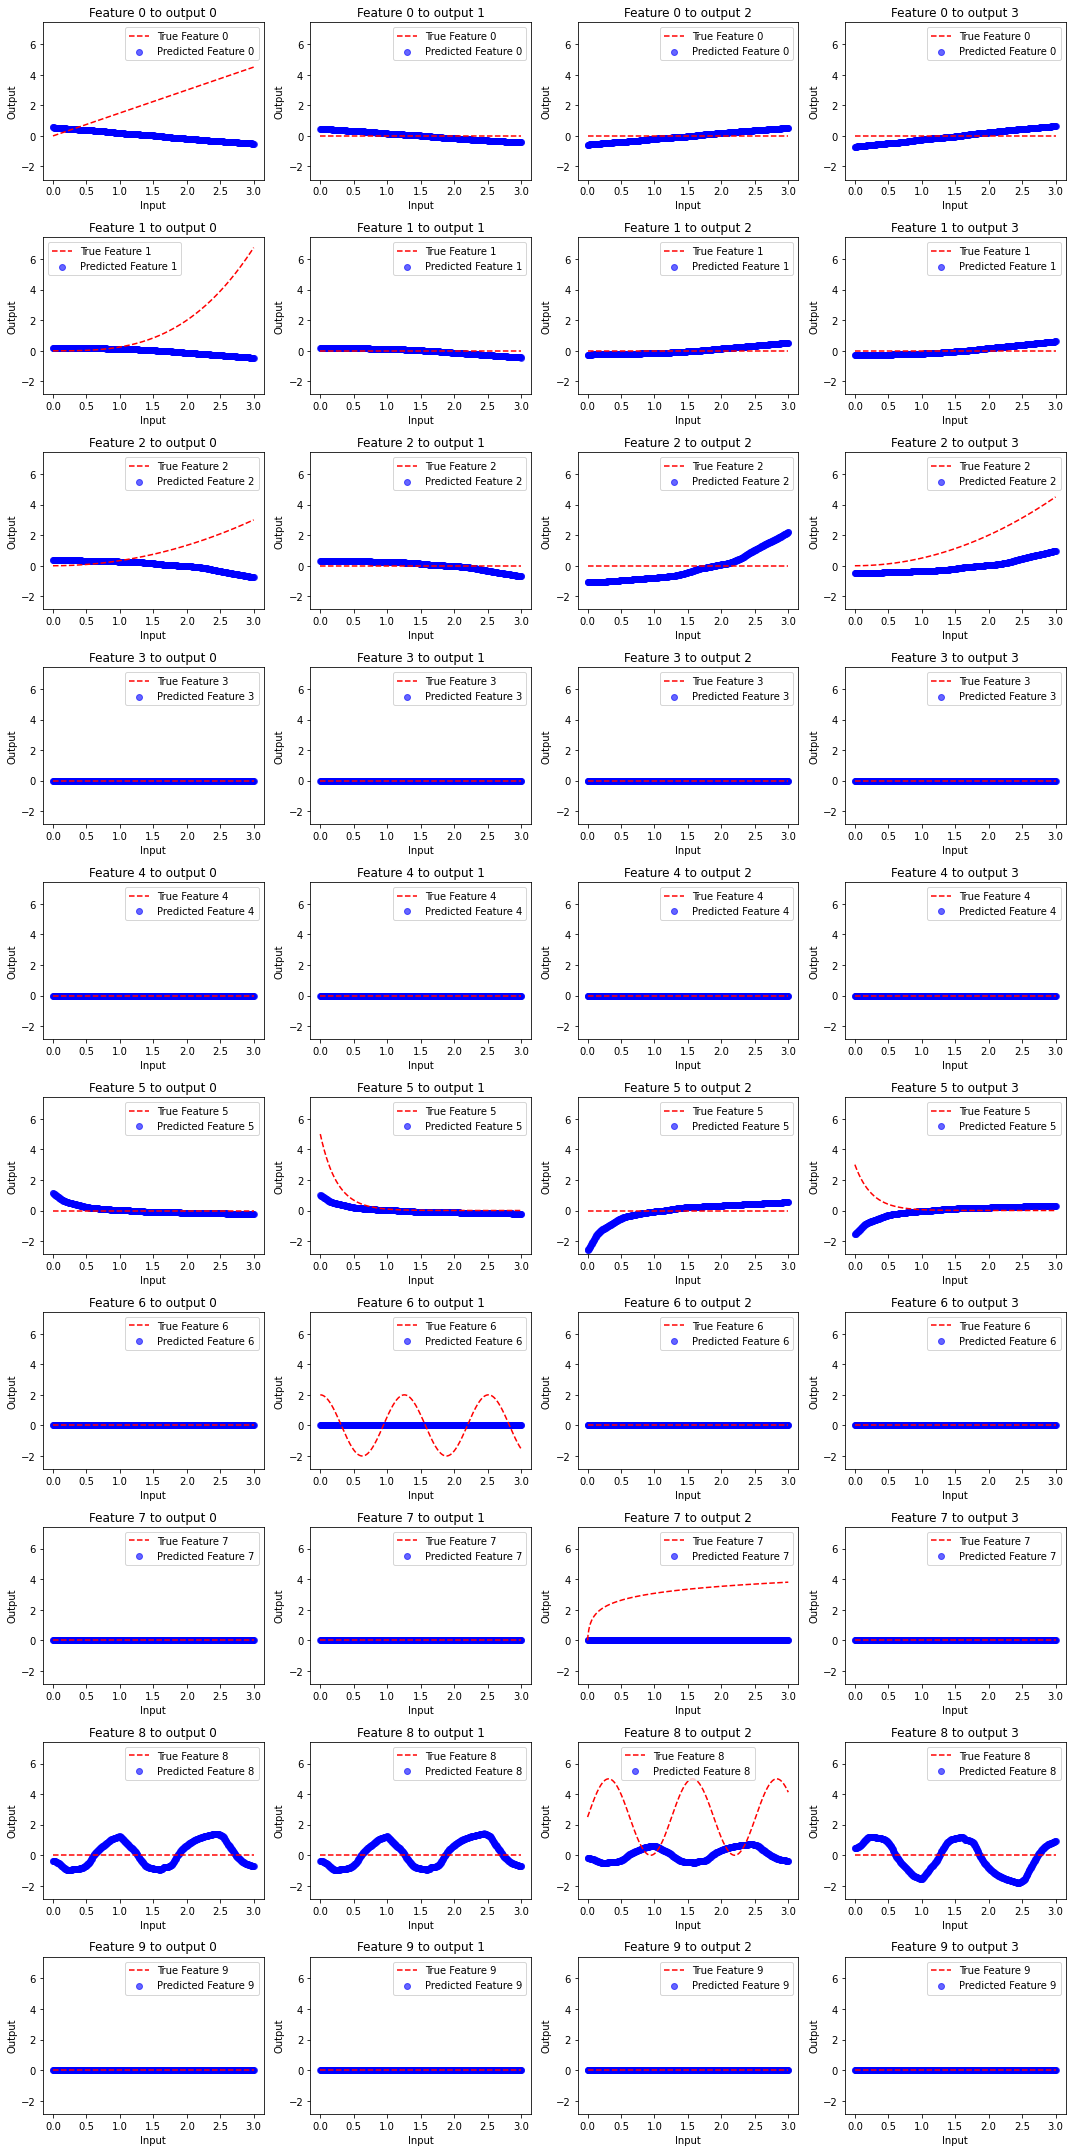

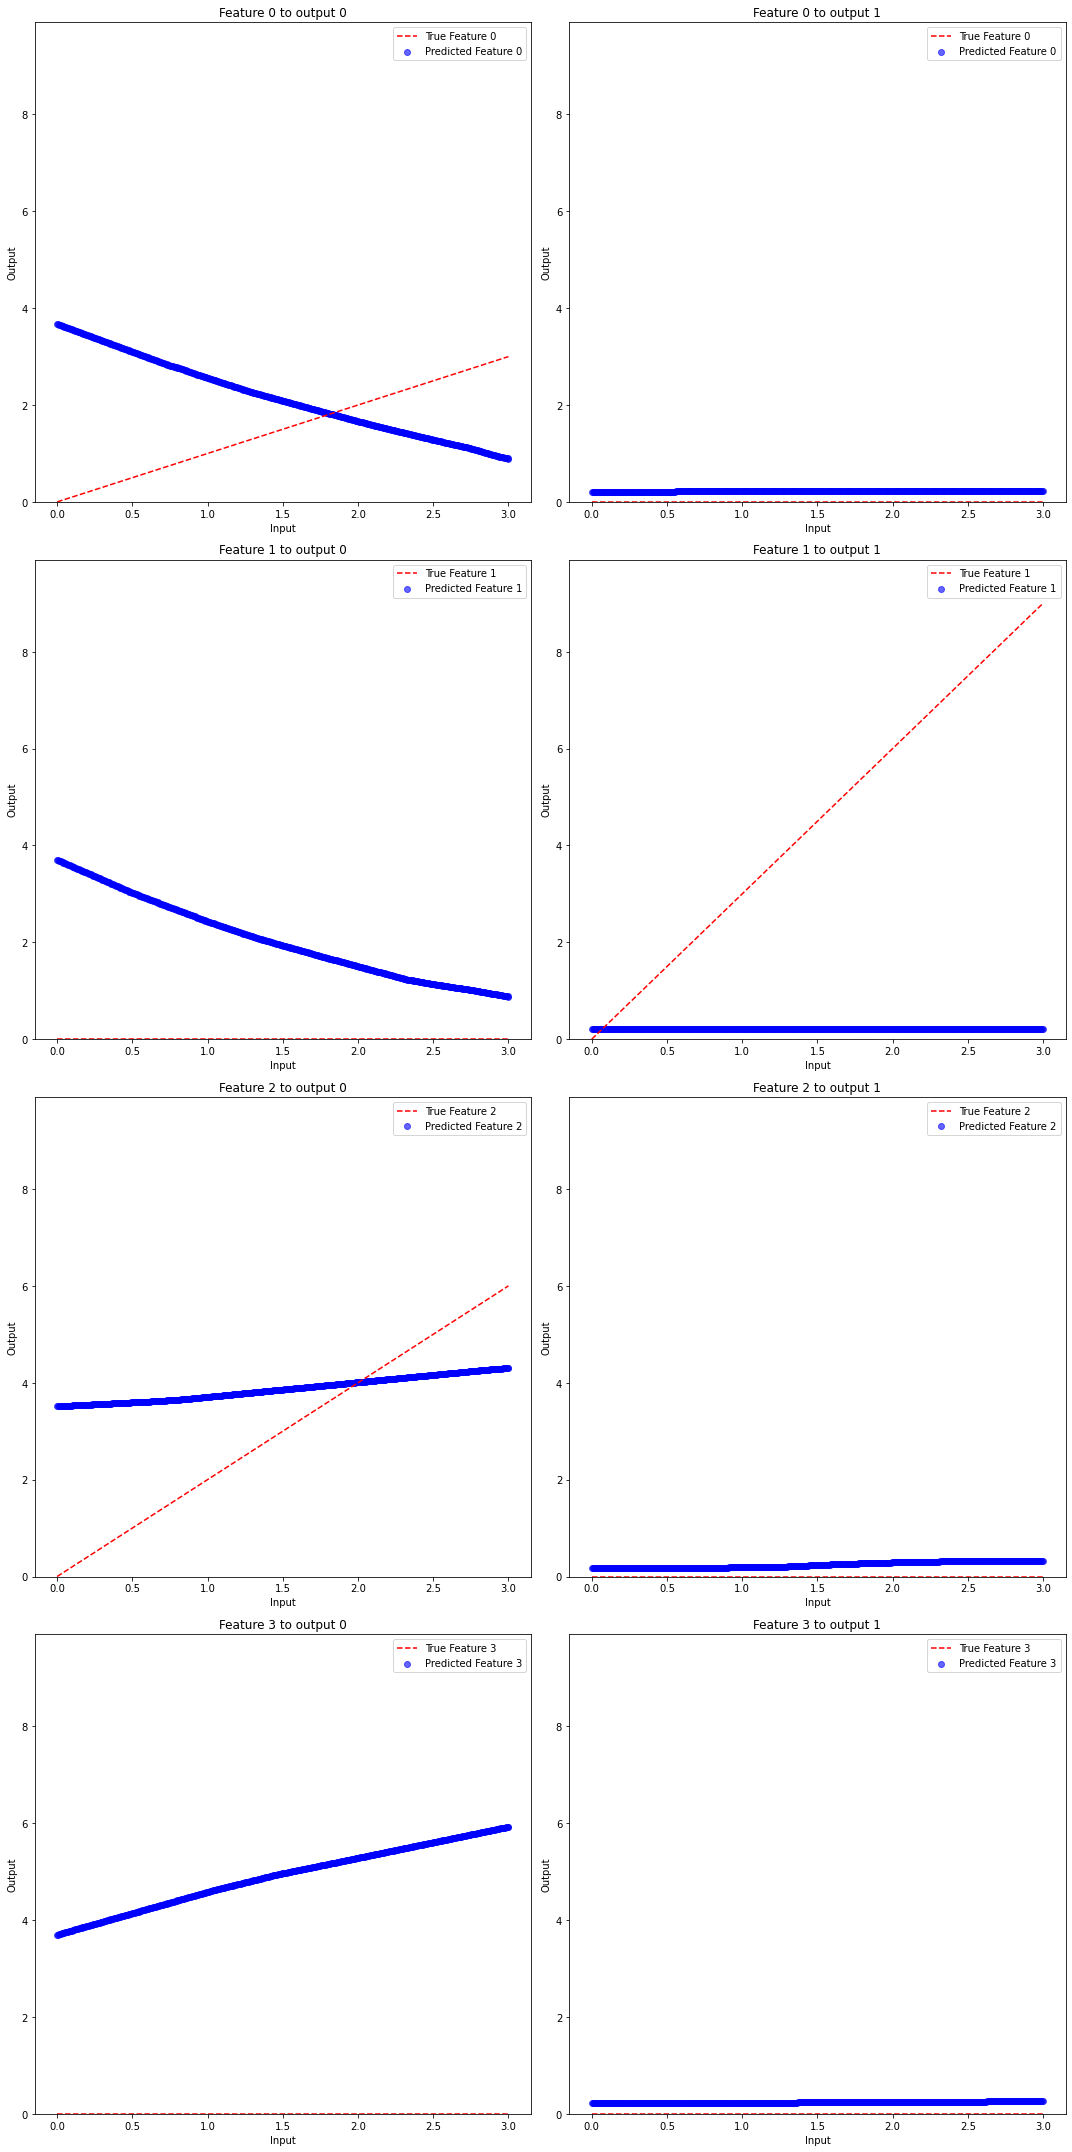

In [34]:
# Visualization of the shape functions created in the two phases
get_shape_functions_synthetic_data1(model, args, num_test_exp=500)

In [38]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

get_shape_functions_synthetic_data(model, args, num_test_exp=500)

<ipython-input-38-e5ded09f66a6>:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



RuntimeError: Error(s) in loading state_dict for HierarchNeuralAdditiveModel:
	Missing key(s) in state_dict: "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.parametrizations.weight.original". 
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).

In [ ]:
train_loss_history_np = [loss for loss in train_loss_history]
val_loss_history_np = [loss for loss in val_loss_history]

plt.figure(figsize=(12, 6))

plt.plot(train_loss_history_np, color='r', label='Training')
plt.plot(val_loss_history_np, color='g', label='Validation')

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")

plt.legend()
plt.show()

In [ ]:
# Generate input values for plotting
x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = True)

# Dataset

In [45]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = -(3/4) * torch.exp(-4 * X[:, 7].abs()) + torch.cos(5 * X[:, 8])
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.sin(5 * X[:, 5]) + 0.5*(3*(X[:, 2]**2)-1)  
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = 4*X_input[:, 0] + 0.5*X_input[:, 1]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * X_input[:, 2] + 5 * X_input[:, 3]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [ ]:
X, y = get_synthetic_data_phase1(num_exp=1, in_features=10)
Y = get_synthetic_data_phase2(y)

# Model architecture

In [47]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, output_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      output_dim=output_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(output_dim))
        
    def forward(self, x):
        # Collect outputs from each feature network
        FeatureNN_out = self._feature_nns(x)
        
        # Concatenates a sequence of tensors along the latent features dimension 
        f_out = torch.stack(FeatureNN_out, dim=-1)
        
        # Sum across features and add bias
        f_out = self.feature_dropout(f_out)
        outputs = f_out.sum(axis=-1) + self.bias
        
        if 0:
            print('final output', outputs)
            print('f_out', f_out)
        return outputs, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]
    

# Hirarchical Neural Additive Model Class
class HierarchNeuralAdditiveModel(torch.nn.Module):
    """
    Hierarch Neural Additive Model
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 latent_feature_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 output_dim: int = 1,
                 ):
        super().__init__()

        self.NAM_features = NeuralAdditiveModel(input_size=input_size,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= feature_dropout,
                                output_dim = latent_var_dim,
                                )
       

        self.NAM_output = NeuralAdditiveModel(input_size=latent_var_dim,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= latent_feature_dropout,
                                output_dim = output_dim,
                                )

    def forward(self, x):
        
        latent_outputs, f_out = self.NAM_features(x)

        outputs, lat_f_out = self.NAM_output(latent_outputs)
       
         # Apply softmax to get class probabilities
#         outputs = torch.softmax(outputs, dim=-1)

        if 0:
            print('x:', x.shape)
            print('latent_outputs:',latent_outputs.shape)
            print('f_out:',f_out.shape)
            print('outputs:',outputs.shape)
            print('lat_f_out:',lat_f_out.shape)  
            
        return outputs, lat_f_out

# Loss

In [48]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [49]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [50]:
# define experiment
config = dict(
    epochs=2000, #100
    batch_size=1024, #128
    learning_rate=0.0035,
    weight_decay=0.0001,
    num_exp = 5000,
    in_features = 10,
    shallow_units=20, #50
    hidden_units=(64, 64, 32), #(100, 20)
    feature_dropout=0.2,
    latent_feature_dropout=0.2,
    hidden_dropout=0.2,
    latent_dim=4,
    output_dim=2,
    seed=42,
    dataset="Uniform_distribution",
    architecture="multi_output_NAM")

In [52]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    train_loader = make_loader(X, Y, batch_size=config['batch_size'])

    # Make the model
    model = HierarchNeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     hidden_dropout = config['hidden_dropout'],
                     feature_dropout = config['feature_dropout'],
                     latent_feature_dropout = config['latent_feature_dropout'],
                     latent_var_dim = config['latent_dim'], 
                     output_dim = config['output_dim'],     
                     ).to(device)
    
#     model = NeuralAdditiveModel(input_size= config['in_features'],
#                      shallow_units= config['shallow_units'],
#                      hidden_units= config['hidden_units'],
#                      shallow_layer = ExULayer,
#                      hidden_layer = ReLULayer,
#                      hidden_dropout = config['hidden_dropout'],
#                      feature_dropout = config['feature_dropout'],
#                      output_dim = config['latent_dim'],           
#                      ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

# Run

In [ ]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
model

In [ ]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

# Visualaize shape functions

In [40]:
def get_shape_functions(model, args):
    # Generate input values for plotting
    x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

    input_dim = args.latent_dim
    output_dim = args.output_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

    input_dim = args.in_features
    output_dim = args.latent_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)
    return

def visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                #ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

In [ ]:
get_shape_functions(model, args)



In [15]:
def visualize_true_gam(input_dim, output_dim, shape_functions, x_values):
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    for i in range(input_dim):
        for j in range(output_dim):
            ax1 = axes[i, j]
            feature_output = shape_functions[f'f_{j}_{i}']
                
            ax1.scatter(x_values, feature_output, label=f'Feature {i+1}')
            ax1.set_title(f'Feature {i+1} to output {j}')
            ax1.set_xlabel('Input')
            ax1.set_ylabel('Output')
            
    plt.tight_layout()
    plt.show()
    return

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase2, x_values)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase1, x_values)

In [7]:
import matplotlib.pyplot as plt

def visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions, vis_lat_features=False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Initialize global min and max for setting the y-limits
    global_min = float('inf')
    global_max = float('-inf')

    # First pass: Determine the global min and max across all predicted and true shape functions
    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                # Predicted shape function
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                # Get true shape function
                true_feature_output = shape_functions[f'f_{j}_{i}'].cpu().numpy()
                # Update global min and max
                global_min = min(global_min, feature_output.min(), true_feature_output.min())
                global_max = max(global_max, feature_output.max(), true_feature_output.max())

    # Second pass: Plot the predicted and true shape functions with consistent y-limits
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                # Get the true shape function for this feature-output pair
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Plot the predicted shape function
                ax1 = axes[i, j]
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Predicted Feature {i}', color='blue', alpha=0.6)
                
                # Plot the true shape function
                ax1.plot(x_values.cpu().numpy(), true_feature_output, label=f'True Feature {i}', color='red', linestyle='--')

                # Set labels and title
                ax1.set_title(f'Feature {i} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')

                # Set consistent y-limits across all plots
                ax1.set_ylim([global_min * 1.3, global_max * 1.3])  # Adjust the limits slightly for better visualization

                # Add legend
                ax1.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

# input_dim = args.latent_dim
# output_dim = args.output_dim
# visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase2)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase1, vis_lat_features=True)
